In [5]:
from counter import counter
cc = counter('count-cooc-top20k-strat30-WoS-econ')

Loading count-cooc-top20k-strat30-WoS-econ from disk...


In [6]:
import numpy as np

In [7]:
from matplotlib import pyplot as plt

In [8]:
len(cc.items('t'))

1500

# the math

$$ \frac{ \text{count-t}(a) }{ \sum \text{count-t}(a) } = 1 $$
$$ \sum_b{ \text{count-t.t}(a,b) } = 5 \sum \text{count-t}(a) $$

$$ P( \text{b shows up after a} ) = 1 - \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] } $$

$$ P( w_{j+N} = b | w_j = a ) = ?? $$

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) \in [0, 5] $$

Now I want to measure how surprising a given connection is compared to the individual propensities.
Something similar to // independence indicates that

$$P(A \& B) = P(A) * P(B|A) = P(A) * P(B)$$

Where the last equality expresses the independence assumption. The extent to which the leftmost and rightmost quantities differ is a good measure for the relevance of a single tie between events.
So, assume $a$ and $b$ are independent events. From above we know that

$$P(a \to b) = \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] }$$

And by independence this is just

$$ \prod_N{ \left[ 1 - P( w_{j+N} = b ) \right] } $$

$$ P( w_{j+N} = b ) = \text{count-t}(b) * 5 $$

So we almost get what we want... Let's try another combo of formulas...

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) $$
$$ = \sum_{N=1}^5 P( w_{j+N} = b ) = \sum_{N=1}^5 \frac{ \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} } = \frac{ 5 * \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} }  $$

By this math the relevant ratio is

$$ \frac{ \text{count-t.t}(a,b) * \sum_b{\text{count-t}(b)} }{ \text{count-t}(a) * \text{count-t}(b) } = 5 $$

# generate the network

In [9]:
cc.counts.keys()

dict_keys([('fy', 't'), ('fj', 't'), ('fy',), ('t',), ('fj',), ('t1', 't2'), ('fy', 't1', 't2')])

In [10]:
tot = cc.counts[('t',)].sum()
terms = cc.items('t')

In [11]:
rats = []
pairs = []

for t1 in terms:
    for t2 in terms:
        if t1 == t2:
            continue
        
        ca = cc(t=t1)
        cb = cc(t=t2)
        cab = cc(t1=t1, t2=t2)
        
        if cab < 10 or ca < 10 or cb < 10:
            continue

        rat = tot * cab / (ca * cb)
        pairs.append( (cc.ids['t'][t1], cc.ids['t'][t2]) )
        rats.append( rat )

In [12]:
rats = np.array(rats)

In [13]:
np.argwhere( rats > 250 ).shape

(1173, 1)

In [14]:
np.argwhere( rats < 250 ).shape

(11410, 1)

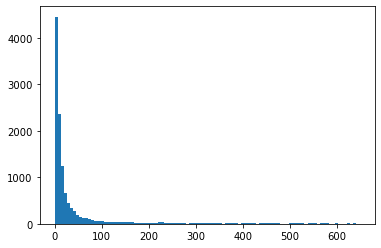

In [15]:
plt.hist( rats[(rats<250+400)&(rats>0)], bins=100 );

In [16]:
np.mean(rats)

101.46262940701719

In [17]:
np.quantile(rats, 0.9)

226.89770129716564

In [18]:
from random import sample

In [20]:
tops = np.argwhere( rats > np.quantile(rats, 0.99) ).flatten()
tops = list(tops)

for i in sample( tops, 100 ):
    ai, bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    ac = cc.counts[('t',)][ai]
    bc = cc.counts[('t',)][bi]
    abc = cc.counts[('t1','t2')][(ai,bi)]
    bac = cc.counts[('t1','t2')][(bi,ai)]
    print( (at, bt, rats[i], ac, bc, abc, bac) )

('properties', 'properties-of', 1975.8839779005525, 181, 149, 0, 0)
('in-australia', 'australia', 2554.535714285714, 84, 140, 0, 0)
('comparative-advantage', 'advantage', 3663.3546734955185, 71, 99, 0, 0)
('moral', 'moral-hazard', 3251.2272727272725, 110, 70, 0, 0)
('the-thcentury', 'thcentury', 1916.8632941884975, 81, 205, 0, 0)
('approaches', 'approaches-to', 2569.358938933407, 141, 77, 0, 0)
('kuznets-curve', 'curve', 1943.6684782608695, 60, 184, 0, 0)
('gains', 'gains-from', 2116.183431952663, 169, 77, 0, 0)
('elasticity', 'elasticity-of', 2536.418439716312, 141, 106, 0, 0)
('an-empiricalanalysis', 'empiricalanalysis', 2368.4437086092717, 97, 151, 0, 0)
('the-financial', 'financial-crisis', 1873.7003549095825, 97, 61, 0, 0)
('empiricalanalysis', 'empiricalanalysis-of', 2368.4437086092717, 151, 68, 0, 0)
('the-dynamics', 'dynamics-of', 2337.483660130719, 77, 153, 1, 0)
('significance', 'significance-of', 3311.435185185185, 108, 66, 0, 0)
('wage-differentials', 'differentials', 2360.

# dump network

In [113]:
import networkx as nx

In [136]:
rats = np.array(rats)
cutoff = np.quantile(rats[rats>0], 0.93)
cutoff

377.5702622060917

In [137]:
G = nx.DiGraph()

edges = []

for i, r in enumerate(rats):
    if r < cutoff:
        continue
    
    ai,bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    edges.append( [at,bt,r] )

G.add_weighted_edges_from(edges)

In [138]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items()])

In [139]:
deg = np.array(list(x[1] for x in G.degree()))

In [140]:
DEG_CUTOFF = 2
print(
    np.where( deg >= DEG_CUTOFF )[0].shape,
    np.where( deg < DEG_CUTOFF )[0].shape
)

G.remove_nodes_from( list(np.where( deg < DEG_CUTOFF )[0]) )

(481,) (489,)


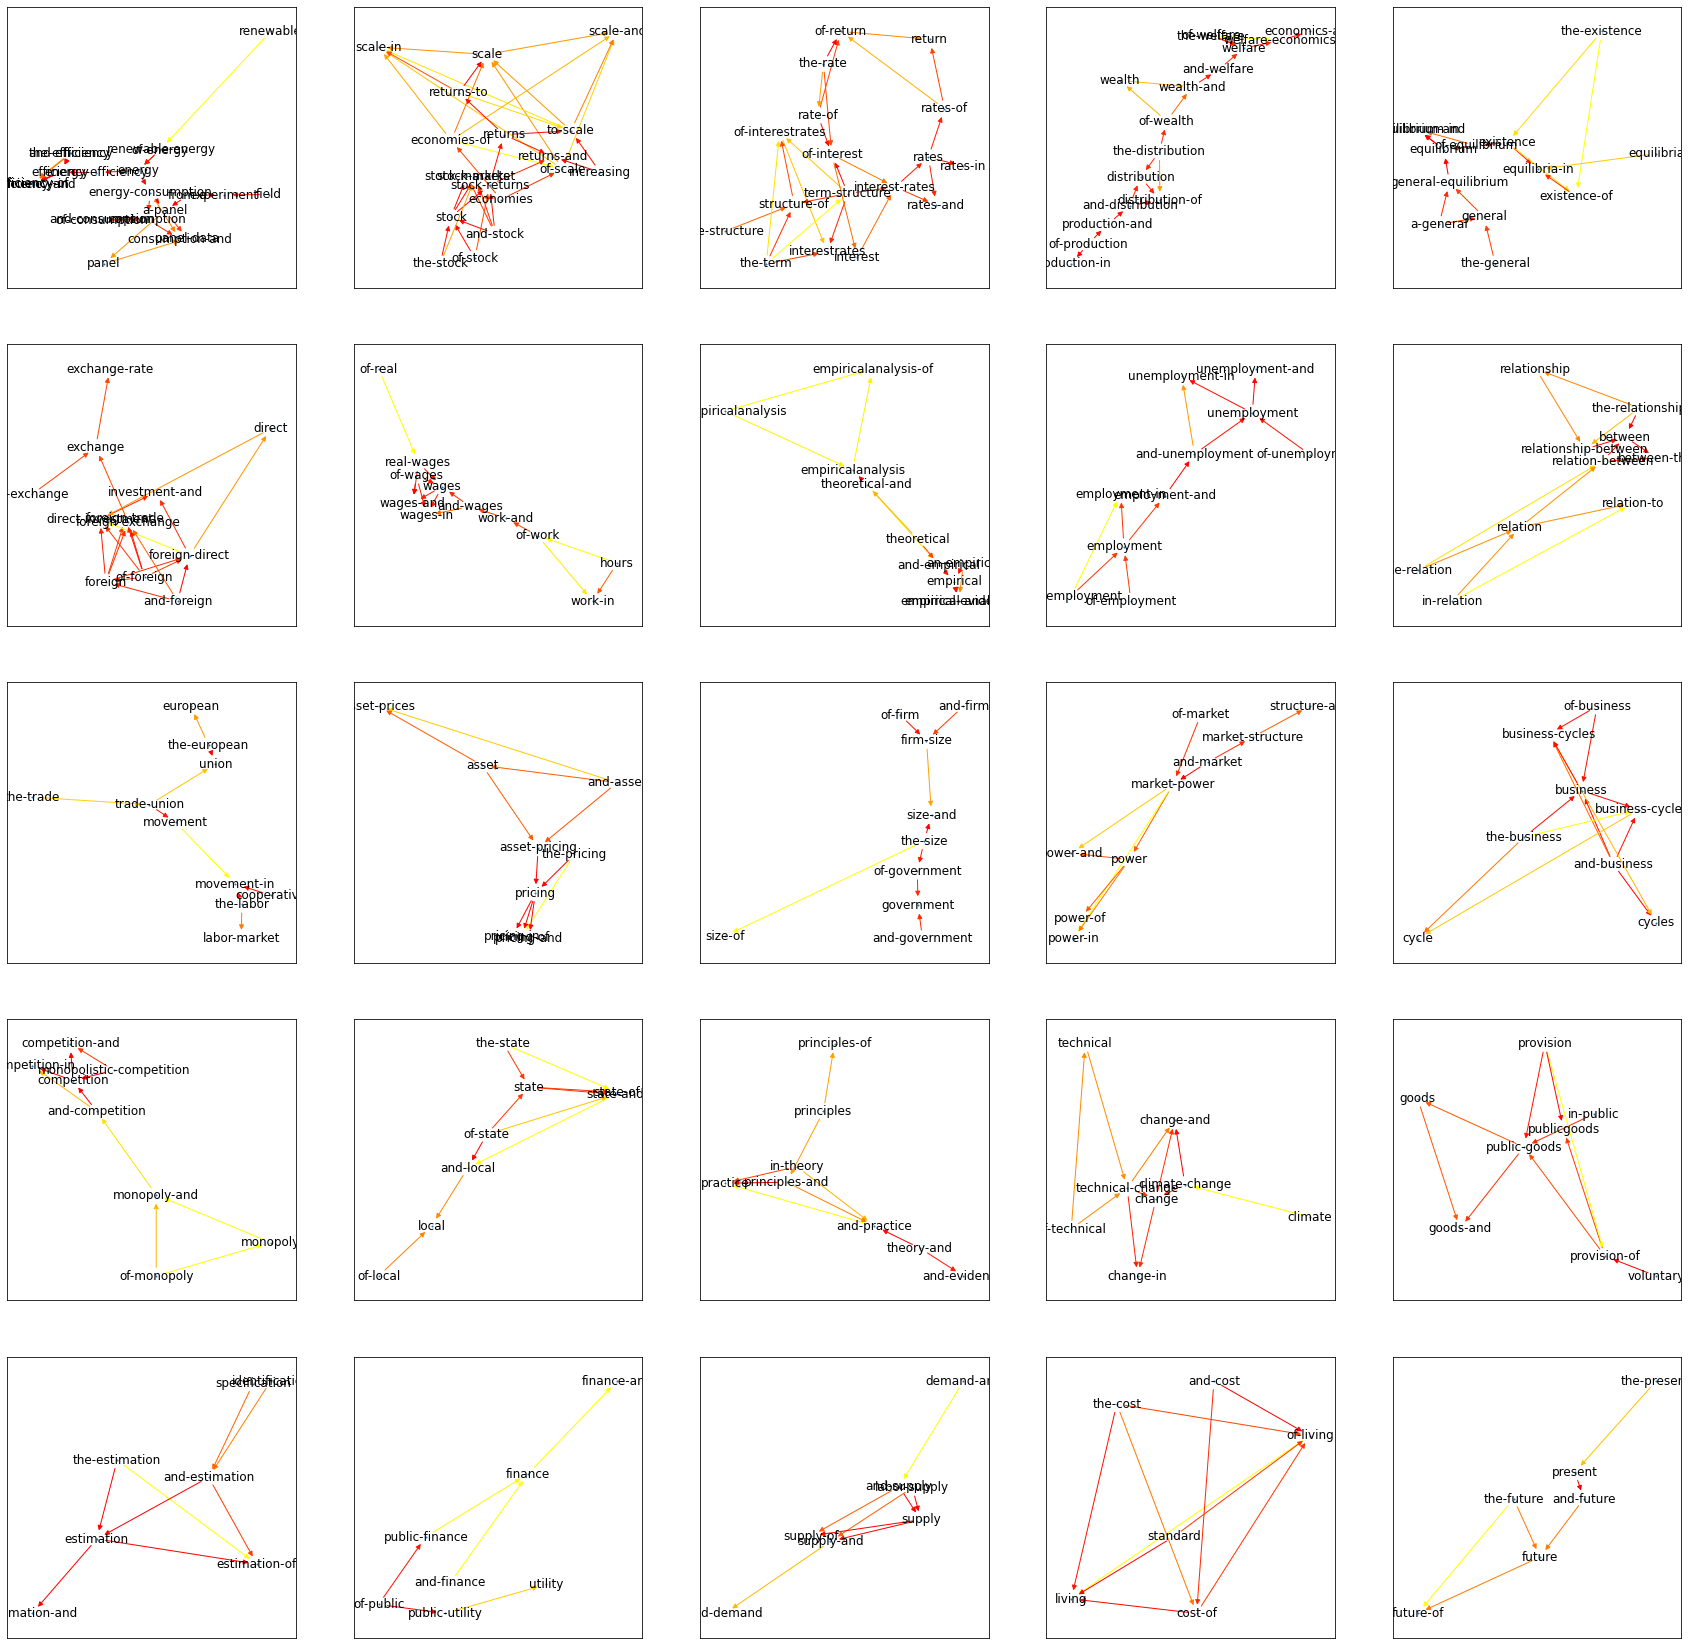

In [141]:
R, C = 5, 5

nodes_list = list(nx.connected_components(G.to_undirected()))
nodes_list = sorted(nodes_list, key=lambda x:-len(x))

plt.figure(figsize=(6*R,6*C))

for i,Gcomp_nodes in enumerate(nodes_list[:R*C]):
    plt.subplot(R,C,i+1)
    Gcomp = nx.subgraph(G, Gcomp_nodes)
    pos = nx.kamada_kawai_layout(Gcomp)


    edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(Gcomp,'weight').items()])

    c = np.log(weights)
    c /= c.max()

    nx.draw_networkx_edges(Gcomp,pos,edgelist=edges,edge_cmap=plt.cm.autumn,edge_color=c)
    nx.draw_networkx_nodes(Gcomp,pos,node_size=1)
    nx.draw_networkx_labels(Gcomp,pos)